# **Loss Functions for Real Time Series**

First, we import both the project modules and the necessary libraries:

In [6]:
from src.dnn.utils import train_and_predict, l_infinity_loss, quantile_loss_fn, create_sequences_from_series
from src.yahoo_apis.classes import YahooFinanceAPI

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import Dict
from datetime import datetime
import re

### Time Series Simulation

Download real data to use:

In [7]:
yf_api = YahooFinanceAPI()
apple = yf_api.download_data("AAPL", datetime(year=2022, month=1, day=1), datetime(year=2025, month=6, day=25))
btc_1 = yf_api.download_data("BTC-USD", datetime(year=2020, month=1, day=1), datetime(year=2025, month=1, day=1))
btc_2 = yf_api.download_data("BTC-USD", datetime(year=2018, month=1, day=1), datetime(year=2021, month=1, day=1))
zcf = yf_api.download_data("ZC=F",datetime(year=2016, month=1, day=1), datetime(year=2020, month=1, day=1))

data_dict: Dict[str, np.ndarray] = {
    "AAPL": apple,
    "BTC-USD_1": btc_1,
    "BTC-USD_2": btc_2,
    "ZC=F": zcf
}

index_dict: Dict[str, np.ndarray] = {
    "AAPL": np.arange(datetime(year=2022, month=1, day=1), datetime(year=2025, month=6, day=25), np.timedelta64(1, 'D')),
    "BTC-USD_1": np.arange(datetime(year=2020, month=1, day=1), datetime(year=2025, month=1, day=1), np.timedelta64(1, 'D')),
    "BTC-USD_2": np.arange(datetime(year=2018, month=1, day=1), datetime(year=2021, month=1, day=1), np.timedelta64(1, 'D')),
    "ZC=F": np.arange(datetime(year=2016, month=1, day=1), datetime(year=2020, month=1, day=1), np.timedelta64(1, 'D'))
}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Train ANNs

Define loss functions and ANN parameters

In [64]:
loss_functions = {
    "L_1": "mae",
    "L_2": "mse",
    "L_inf": l_infinity_loss,
    "Quantile_0.1": quantile_loss_fn(0.1),
    "Quantile_0.9": quantile_loss_fn(0.9),
}

seq_length = 1
batch_size = 32
epochs = 250
learning_rate = 0.01

preds = {}
results = {}
histories = {}

Train the different ANNs and obtain the predictions for each possible time series and each possible loss function

In [65]:
for ticker, prices in data_dict.items():

    X, y = create_sequences_from_series(prices, seq_length)
    
    for key, loss_fn in loss_functions.items():
        print(f"\nTraining {ticker} with {key} loss")
        predictions, history = train_and_predict(
            X=X,
            y=y,
            loss_function=loss_fn,
            seq_length=seq_length,
            batch_size=32,
            epochs=250,
            learning_rate=0.01
        )
        
        preds_inv = predictions.flatten()
        y_inv = y.reshape(-1, 1).flatten()
            
        preds[f"{ticker}_{key}"] = preds_inv
        histories[f"{ticker}_{key}"]  = history


Training AAPL with L_1 loss
Epoch 1/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.9270 - mae: 49.9270 - mape: 27.3571 - mse: 4427.4404      
Epoch 2/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8871 - mae: 4.8871 - mape: 2.6811 - mse: 35.4577 
Epoch 3/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5003 - mae: 2.5003 - mape: 1.4152 - mse: 11.4445
Epoch 4/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5671 - mae: 2.5671 - mape: 1.4387 - mse: 13.2425
Epoch 5/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8100 - mae: 2.8100 - mape: 1.5724 - mse: 12.8940 
Epoch 6/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6272 - mae: 4.6272 - mape: 2.5552 - mse: 30.8380 
Epoch 7/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9111 - mae: 2.9111 - mape: 1.6322 - mse: 15.4623
Epoch 8/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7382 - mae: 2.7382 - mape: 1.5421 - mse: 13.6224 
Epoch 9/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4998 - mae: 2.4

Create ANN learning curves for each time series with a specific noise:

In [66]:
base_dir = os.path.join(os.getcwd(), "experiments", "real_ts")
plot_dir = os.path.join(base_dir, "learning_curves")
os.makedirs(plot_dir, exist_ok=True)

def safe_name(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9_.-]+', '-', str(s))

use_log_scale = True

for series_name in data_dict.keys():
    series_dir = os.path.join(plot_dir, safe_name(series_name))
    os.makedirs(series_dir, exist_ok=True)

    for loss_name in loss_functions.keys():
        key = f"{series_name}_{loss_name}"
        if key not in histories:
            alt_key = f"{series_name}_{loss_name.replace('_', '')}"
            if alt_key in histories:
                key = alt_key

        hist = histories[key].history
        train = hist.get("loss", None)
        val   = hist.get("val_loss", None)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(train, label=f"{loss_name} (train)")
        if val is not None:
            ax.plot(val, label=f"{loss_name} (val)", linestyle="--")

        if use_log_scale:
            ax.set_yscale("log")

        ax.set_title(f"Learning Curve — Dist='{series_name}' — Loss='{loss_name}'")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(fontsize="small")
        ax.grid(True)
        plt.tight_layout()

        fname = f"learning_curve_{safe_name(series_name)}_{safe_name(loss_name)}.png"
        out_path = os.path.join(series_dir, fname)
        fig.savefig(out_path, dpi=150)
        plt.close(fig)

We now look at the differences between L1 and L2:

In [67]:
# =========================
# Difference plots (L1-L2 y Q0.9-Q0.1) con ejes alineados
# =========================
base_dir = os.path.join(os.getcwd(), "experiments", "real_ts")
diff_plot_dir = os.path.join(base_dir, "difference_plots")
os.makedirs(diff_plot_dir, exist_ok=True)

def aligned_x_axis(series_name: str, diff_len: int) -> np.ndarray:
    """
    Devuelve un eje X de longitud diff_len.
    - Si index_dict[series_name] tiene suficiente longitud, usa fechas desde el offset 1 (porque y_t empieza en t=1).
    - Si no, retorna un eje numérico 0..diff_len-1.
    """
    idx = np.asarray(index_dict[series_name])
    if idx.shape[0] >= diff_len + 1:
        return idx[1:1+diff_len]  # alinea con y_t (predicciones) que empiezan en t=1
    # fallback numérico si el índice calendario es más corto o inexistente
    return np.arange(diff_len)

for series_name, prices in data_dict.items():
    T = len(prices)  # nº de observaciones reales (días de mercado)
    # --- L1 vs L2 ---
    k1 = f"{series_name}_L_1"
    k2 = f"{series_name}_L_2"
    if k1 in preds and k2 in preds:
        l1 = np.asarray(preds[k1]).ravel()
        l2 = np.asarray(preds[k2]).ravel()
        # Recorta a la longitud común por seguridad
        m = min(l1.size, l2.size, max(T-1, 0))
        if m > 0:
            diff_l1_l2 = l1[:m] - l2[:m]
            x_axis = aligned_x_axis(series_name, m)

            mean_diff = float(np.mean(diff_l1_l2))

            plt.figure(figsize=(10, 6))
            plt.plot(x_axis, diff_l1_l2, label="L1 - L2 Difference", color="purple")
            plt.axhline(y=mean_diff, color='blue', linestyle='-.',
                        label=f'Mean Difference: {mean_diff:.4f}')
            plt.title(f"Difference Between L1 and L2 Predictions — {series_name}")
            plt.xlabel("Time")
            plt.ylabel("Difference")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            fname = f"diff_L1_L2_{safe_name(series_name)}.png"
            out_path = os.path.join(diff_plot_dir, fname)
            plt.savefig(out_path, dpi=150)
            plt.close()

    # --- Q0.9 vs Q0.1 ---
    kq9 = f"{series_name}_Quantile_0.9"
    kq1 = f"{series_name}_Quantile_0.1"
    if kq9 in preds and kq1 in preds:
        q9 = np.asarray(preds[kq9]).ravel()
        q1 = np.asarray(preds[kq1]).ravel()
        m = min(q9.size, q1.size, max(T-1, 0))
        if m > 0:
            diff_q9_q1 = q9[:m] - q1[:m]
            x_axis = aligned_x_axis(series_name, m)

            mean_diff = float(np.mean(diff_q9_q1))

            plt.figure(figsize=(10, 6))
            plt.plot(x_axis, diff_q9_q1, label="0.9 Quantile - 0.1 Quantile Difference", color="orange")
            plt.axhline(y=mean_diff, color='blue', linestyle='-.',
                        label=f'Mean Difference: {mean_diff:.4f}')
            plt.title(f"Difference Between 0.9 and 0.1 Quantile Predictions — {series_name}")
            plt.xlabel("Time")
            plt.ylabel("Difference")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            fname = f"diff_Quantiles_{safe_name(series_name)}.png"
            out_path = os.path.join(diff_plot_dir, fname)
            plt.savefig(out_path, dpi=150)
            plt.close()


Create prediction plots for time series with various noises (separetely):

In [68]:
# =========================
# Prediction plots (alineados y con parseo robusto de claves)
# =========================
base_dir = os.path.join(os.getcwd(), "experiments", "real_ts")
plot_dir = os.path.join(base_dir, "prediction_plots")
os.makedirs(plot_dir, exist_ok=True)

def split_series_and_loss(key: str, known_series: list) -> tuple[str, str]:
    """
    Extrae (series_name, loss_name) de una clave como 'BTC-USD_1_L_2'.
    Busca el match más largo entre los tickers conocidos (terminado en '_').
    Si no encuentra, cae a split('_',1).
    """
    # match más largo primero
    for s in sorted(known_series, key=len, reverse=True):
        pref = f"{s}_"
        if key.startswith(pref):
            return s, key[len(pref):]
    # fallback
    if "_" in key:
        s, loss = key.split("_", 1)
        return s, loss
    return key, "unknown"

def aligned_pred_axis(series_name: str, pred_len: int) -> np.ndarray:
    """
    Eje X para las predicciones one-step-ahead (longitud pred_len).
    Usa index_dict[serie][1:1+pred_len] si alcanza; si no, un eje numérico.
    """
    idx = np.asarray(index_dict[series_name])
    if idx.shape[0] >= pred_len + 1:
        return idx[1:1+pred_len]
    return np.arange(pred_len)

for key, pred_array in preds.items():
    series_name, loss_name = split_series_and_loss(key, list(data_dict.keys()))
    series_dir = os.path.join(plot_dir, safe_name(series_name))
    os.makedirs(series_dir, exist_ok=True)

    # Señal real y su índice (recortado por si el índice calendario es más largo)
    prices = np.asarray(data_dict[series_name]).ravel()
    idx_full = np.asarray(index_dict[series_name])
    idx_true = idx_full[:len(prices)]

    # Predicciones a vector 1D y ejes alineados
    y_pred = np.asarray(pred_array).ravel()
    # Longitud válida: min(T-1, len(pred))
    m = min(max(len(prices) - 1, 0), y_pred.size)
    if m == 0:
        continue
    x_pred = aligned_pred_axis(series_name, m)
    y_pred = y_pred[:m]

    plt.figure(figsize=(10, 6))
    plt.plot(
        idx_true, prices,
        label="True Signal",
        alpha=1, color="black", linestyle="--"
    )
    plt.plot(
        x_pred, y_pred,
        label=f"Prediction ({loss_name})",
        linestyle='-', color="blue", alpha=0.8
    )
    plt.title(f"ANN Prediction — Series: {series_name} | Loss: {loss_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fname = f"pred_{safe_name(series_name)}_{safe_name(loss_name)}.png"
    out_path = os.path.join(series_dir, fname)
    plt.savefig(out_path, dpi=150)
    plt.close()


Create grid error distributions histograms for the predictions

In [69]:
# =========================
# Error histograms (pares L1/L2 + otros; sin L_inf)
# =========================
base_dir = os.path.join(os.getcwd(), "experiments", "real_ts")
hist_dir = os.path.join(base_dir, "error_histograms")
os.makedirs(hist_dir, exist_ok=True)

bins = 150
alpha = 0.5

def unique_preserve_order(xs):
    seen, out = set(), []
    for x in xs:
        if x not in seen:
            seen.add(x); out.append(x)
    return out

def norm_loss_name(name: str) -> str:
    s = str(name).strip().lower().replace(' ', '').replace('_', '').replace('-', '').replace('∞', 'inf')
    if s in ('l1', 'mae'): return 'L1'
    if s in ('l2', 'mse'): return 'L2'
    if s in ('linf', 'linfinity', 'linfty'): return 'L_inf'
    return name  # Quantile_0.1, etc.

def split_series_and_loss(key: str, known_series: list) -> tuple[str, str]:
    """Encuentra (series_name, loss_name) buscando el prefijo más largo que sea un ticker conocido."""
    for s in sorted(known_series, key=len, reverse=True):
        pref = f"{s}_"
        if key.startswith(pref):
            return s, key[len(pref):]
    # Fallback
    if '_' in key:
        s, loss = key.split('_', 1)
        return s, loss
    return key, "unknown"

for series_name, prices in data_dict.items():
    prices = np.asarray(prices).ravel()
    if prices.size < 2:
        continue
    y_true_full = prices[1:]  # one-step ahead ground truth

    # 1) Recolecta errores por pérdida para esta serie
    errors = {}
    for key, pred_array in preds.items():
        s, loss_name = split_series_and_loss(key, list(data_dict.keys()))
        if s != series_name:
            continue
        pred_line = np.asarray(pred_array).ravel()
        m = min(pred_line.size, y_true_full.size)
        if m == 0:
            continue
        err = pred_line[:m] - y_true_full[:m]
        errors[loss_name] = err

    if not errors:
        continue

    # 2) Filtra L_inf y ordena priorizando L1/L2
    loss_names_all = list(errors.keys())
    loss_names_no_linf = [ln for ln in loss_names_all if norm_loss_name(ln) != 'L_inf']

    preferred = []
    for tag in ('L1', 'L2'):
        for ln in loss_names_no_linf:
            if norm_loss_name(ln) == tag:
                preferred.append(ln); break
    others = [ln for ln in loss_names_no_linf if ln not in preferred]
    ordered = unique_preserve_order(preferred + others)

    # 3) Selecciona hasta 4 pérdidas y construye pares (2 a 2)
    selected = ordered[:4]
    if len(selected) < 2:
        # no hay con qué comparar
        continue
    # pares: (0,1), (2,3) si existen
    pairs = []
    if len(selected) >= 2:
        pairs.append((selected[0], selected[1]))
    if len(selected) >= 4:
        pairs.append((selected[2], selected[3]))

    ncols = len(pairs)
    if ncols == 0:
        # seguridad extra
        continue

    fig_w = 10 * ncols
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(fig_w, 6), sharex=True, sharey=True)
    axes = np.atleast_1d(axes)

    for i, (ax, (ln1, ln2)) in enumerate(zip(axes, pairs)):
        color1 = f"C{2*i}"
        color2 = f"C{2*i+1}"

        ax.hist(errors[ln1], bins=bins, density=True, alpha=alpha, label=ln1, color=color1)
        ax.hist(errors[ln2], bins=bins, density=True, alpha=alpha, label=ln2, color=color2)

        mean1 = float(np.mean(errors[ln1]))
        mean2 = float(np.mean(errors[ln2]))
        ax.axvline(mean1, linestyle=':', linewidth=2, color=color1, label=f"{ln1} mean")
        ax.axvline(mean2, linestyle=':', linewidth=2, color=color2, label=f"{ln2} mean")

        ax.set_title(f"{series_name} — {ln1} vs {ln2}")
        ax.set_ylabel("Densidad")
        ax.legend(fontsize='small')
        ax.grid(True, linestyle='--', alpha=0.3)

    axes[-1].set_xlabel("Error (ŷₜ – yₜ)")
    plt.tight_layout()

    out_path = os.path.join(hist_dir, f"grid2_hist_errors_{safe_name(series_name)}.png")
    fig.savefig(out_path, dpi=150)
    plt.close(fig)


We compare the different predictions:

In [70]:
base_dir = os.path.join(os.getcwd(), "experiments", "real_ts")
grid_pred_dir = os.path.join(base_dir, "grid_predictions")
os.makedirs(grid_pred_dir, exist_ok=True)

def get_idx_true(series_name: str, prices: np.ndarray) -> np.ndarray:
    """Índice temporal para la serie real, recortado a len(prices).
    Si el índice calendario no alcanza, cae a un eje numérico."""
    idx = np.asarray(index_dict[series_name])
    if idx.shape[0] >= len(prices):
        return idx[:len(prices)]
    return np.arange(len(prices))

def aligned_pred_axis(series_name: str, pred_len: int) -> np.ndarray:
    """Índice para predicciones one-step-ahead (longitud pred_len).
    Usa idx_true[1:1+pred_len] si alcanza; si no, eje numérico."""
    idx_true = get_idx_true(series_name, np.asarray(data_dict[series_name]))
    if idx_true.shape[0] >= pred_len + 1:
        return idx_true[1:1+pred_len]
    return np.arange(pred_len)

def get_pred(series_name: str, key_suffix: str):
    """Devuelve (x_pred, y_pred) alineados si existe la clave, si no (None, None)."""
    key = f"{series_name}_{key_suffix}"
    if key not in preds:
        return None, None
    prices = np.asarray(data_dict[series_name]).ravel()
    y_pred = np.asarray(preds[key]).ravel()
    T = len(prices)
    m = min(max(T - 1, 0), y_pred.size)
    if m == 0:
        return None, None
    return aligned_pred_axis(series_name, m), y_pred[:m]

for series_name, prices in data_dict.items():
    prices = np.asarray(prices).ravel()
    idx_true = get_idx_true(series_name, prices)

    # Recogemos predicciones (pueden faltar)
    x_L2, y_L2 = get_pred(series_name, "L_2")
    x_L1, y_L1 = get_pred(series_name, "L_1")
    x_Q09, y_Q09 = get_pred(series_name, "Quantile_0.9")
    x_Q01, y_Q01 = get_pred(series_name, "Quantile_0.1")

    # Si no hay nada que comparar en ambos paneles, saltamos
    left_has_any = (y_L2 is not None) or (y_L1 is not None)
    right_has_any = (y_Q09 is not None) or (y_Q01 is not None)
    if not (left_has_any or right_has_any):
        continue

    series_dir = os.path.join(grid_pred_dir, safe_name(series_name))
    os.makedirs(series_dir, exist_ok=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), sharex=True, sharey=True)

    # Panel izquierdo: L1 vs L2
    ax = axes[0]
    ax.plot(idx_true, prices, label="True Signal", alpha=1, color="black", linestyle="--")
    if y_L2 is not None:
        ax.plot(x_L2, y_L2, label="Prediction (L_2)", color="red", alpha=0.9)
    if y_L1 is not None:
        ax.plot(x_L1, y_L1, label="Prediction (L_1)", color="blue", alpha=0.9)
    ax.set_title(f"Predictions — {series_name} (L1 vs L2)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend(fontsize="small")
    ax.grid(True, linestyle="--", alpha=0.3)

    # Panel derecho: cuantiles 0.1 vs 0.9
    ax = axes[1]
    ax.plot(idx_true, prices, label="True Signal", alpha=1, color="black", linestyle="--")
    if y_Q09 is not None:
        ax.plot(x_Q09, y_Q09, label="Prediction (Quantile 0.9)", color="orange", alpha=0.9)
    if y_Q01 is not None:
        ax.plot(x_Q01, y_Q01, label="Prediction (Quantile 0.1)", color="purple", alpha=0.9)
    ax.set_title(f"Predictions — {series_name} (Quantiles)")
    ax.set_xlabel("Time")
    ax.legend(fontsize="small")
    ax.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    fname = f"grid_predictions_{safe_name(series_name)}.png"
    out_path = os.path.join(series_dir, fname)
    fig.savefig(out_path, dpi=150)
    plt.close(fig)


We compare how predictions differ

In [71]:
base_dir = os.path.join(os.getcwd(), "experiments", "real_ts")
grid_dir = os.path.join(base_dir, "lag1_scatter_grids")
os.makedirs(grid_dir, exist_ok=True)

for series_name, prices in data_dict.items():

    x_prev = np.asarray(prices[:-1]).ravel()
    y_next = np.asarray(prices[1:]).ravel()

    key_L2 = f"{series_name}_L_2"
    key_L1 = f"{series_name}_L_1"
    key_Q09 = f"{series_name}_Quantile_0.9"
    key_Q01 = f"{series_name}_Quantile_0.1"

    series_dir = os.path.join(grid_dir, safe_name(series_name))
    os.makedirs(series_dir, exist_ok=True)

    order = np.argsort(x_prev)

    def maybe_plot(ax, key, color, label):
        if key in preds:
            yhat = np.asarray(preds[key]).ravel()
            m = min(len(x_prev), len(yhat))
            if m > 0:
                ax.plot(x_prev[order][:m], yhat[order][:m], c=color, lw=1.8, label=label)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), sharex=True, sharey=True)

    ax = axes[0]
    ax.scatter(x_prev, y_next, c="grey", alpha=0.5, s=14, label="(p_{t-1}, p_t)")
    maybe_plot(ax, key_L2, color="red", label="L_2 fit (MSE)")
    maybe_plot(ax, key_L1, color="blue",  label="L_1 fit (MAE)")
    ax.set_title(f"Lag-1 Scatter & Fits — {series_name} (L2/L1)")
    ax.set_xlabel(r"$p_{t-1}$")
    ax.set_ylabel(r"$p_t$")
    ax.legend(fontsize="small")
    ax.grid(True, linestyle="--", alpha=0.3)

    ax = axes[1]
    ax.scatter(x_prev, y_next, c="grey", alpha=0.5, s=14, label="(p_{t-1}, p_t)")
    maybe_plot(ax, key_Q09, color="orange", label="Quantile 0.9 fit")
    maybe_plot(ax, key_Q01, color="purple", label="Quantile 0.1 fit")
    ax.set_title(f"Lag-1 Scatter & Fits — {series_name} (Quantiles)")
    ax.set_xlabel(r"$p_{t-1}$")
    ax.legend(fontsize="small")
    ax.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    fname = f"lag1_scatter_grid_{safe_name(series_name)}.png"
    out_path = os.path.join(series_dir, fname)
    fig.savefig(out_path, dpi=150)
    plt.close(fig)


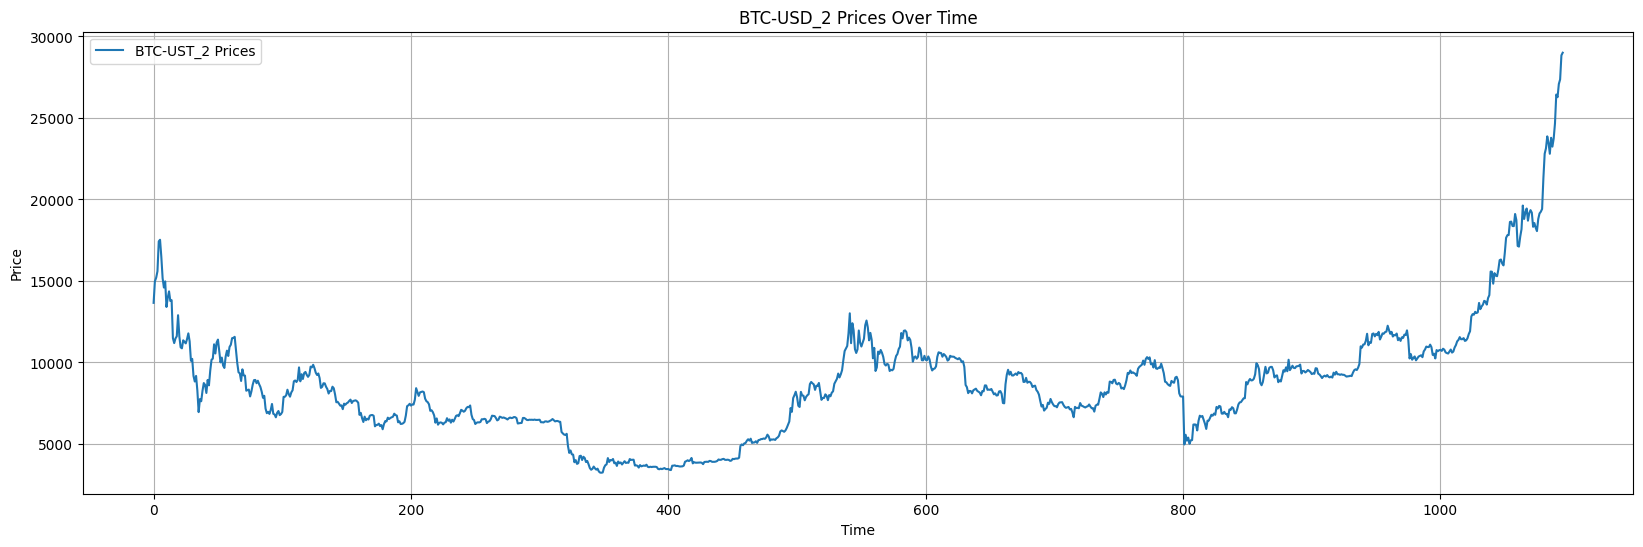

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(data_dict["BTC-USD_2"], label="BTC-UST_2 Prices")
plt.title("BTC-USD_2 Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()